In [18]:
from functions import * # importing our own functions defined in functions.py

import matplotlib.pyplot as plt
plt.style.use(['classic'])
plt.rcParams['figure.facecolor'] = 'white'

For our evaluation, we are using the Adversarial Robustness Toolbox found [here](https://adversarial-robustness-toolbox.readthedocs.io/en/latest/).

# Importing MNIST

In [19]:
from art.utils import load_dataset

(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset(str("cifar10"))
print(min_, max_)

# Training Classifiers

## Generalized Gamma

In [23]:
@tf.custom_gradient
def gamma_activation(x):
    def grad(dy):
        return gamma_derivative(x) * dy

    result = generalized_gamma(x)
    return result, grad

In [24]:
model = define_model(gamma_activation)
classifier = train_model(model, x_train, y_train, x_test, y_test, eps=65)

...created classifier
...finished training
Time to train:  2494.325918197632
Test accuracy: 47.63%

Original test accuracy: 47.63%
(1000, 32, 32, 3)
(1000, 10)
Test set of correctly predicted (benign): 100.00%


In [ ]:
eval_x_test, eval_y_test = get_successful_test(classifier, x_test, y_test)

## ReLU

In [27]:
model_relu = define_model(tf.nn.relu)
classifier_relu = train_model(model_relu, x_train, y_train, x_test, y_test, eps=50)


...created classifier
...finished training
Time to train:  545.4912919998169
Test accuracy: 58.26%

Original test accuracy: 58.26%
(1000, 32, 32, 3)
(1000, 10)
Test set of correctly predicted (benign): 100.00%


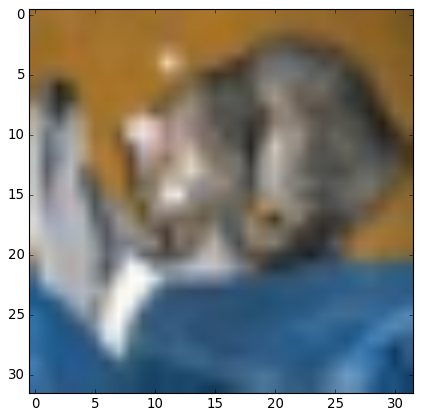

In [28]:
eval_x_test_relu, eval_y_test_relu = get_successful_test(classifier_relu, x_test, y_test)

## Tanh

In [31]:
model_tanh = define_model(tf.nn.tanh)
classifier_tanh = train_model(model_tanh, x_train, y_train, x_test, y_test, eps=50)


...created classifier
...finished training
Time to train:  540.66606092453
Test accuracy: 61.07%

Original test accuracy: 61.07%
(1000, 32, 32, 3)
(1000, 10)
Test set of correctly predicted (benign): 100.00%


In [ ]:
eval_x_test_tanh, eval_y_test_tanh = get_successful_test(classifier_tanh, x_test, y_test)

## Swish

In [32]:
model_swish = define_model(tf.keras.activations.swish)
classifier_swish = train_model(model_swish, x_train, y_train, x_test, y_test, eps=50)


...created classifier
...finished training
Time to train:  657.5527243614197
Test accuracy: 56.14%

Original test accuracy: 56.14%
(1000, 32, 32, 3)
(1000, 10)
Test set of correctly predicted (benign): 100.00%


In [ ]:
eval_x_test_swish, eval_y_test_swish = get_successful_test(classifier_swish, x_test, y_test)

# Attacking Models

## Fast Gradient Sign

In [48]:
fgsm_results_gengamma = []
fgsm_results_relu = []
fgsm_results_tanh = []
fgsm_results_swish = []

eps = np.linspace(0, 0.2, 20)
for epsilon in eps:
    fgsm_results_gengamma += [fgsm_attack(classifier, eval_x_test, eval_y_test, eps=epsilon)]
    fgsm_results_relu += [fgsm_attack(classifier_relu, eval_x_test_relu, eval_y_test_relu, eps=epsilon)]
    fgsm_results_tanh += [fgsm_attack(classifier_tanh, eval_x_test_tanh, eval_y_test_tanh, eps=epsilon)]
    fgsm_results_swish += [fgsm_attack(classifier_swish, eval_x_test_swish, eval_y_test_swish, eps=epsilon)]

    print("eps "+str(epsilon)+" done")

eps 0.0 done
eps 0.006896551724137932 done
eps 0.013793103448275864 done
eps 0.020689655172413796 done
eps 0.027586206896551727 done
eps 0.03448275862068966 done
eps 0.04137931034482759 done
eps 0.048275862068965524 done
eps 0.055172413793103454 done
eps 0.062068965517241385 done
eps 0.06896551724137932 done
eps 0.07586206896551725 done
eps 0.08275862068965519 done
eps 0.08965517241379312 done
eps 0.09655172413793105 done
eps 0.10344827586206898 done
eps 0.11034482758620691 done
eps 0.11724137931034484 done
eps 0.12413793103448277 done
eps 0.1310344827586207 done
eps 0.13793103448275865 done
eps 0.14482758620689656 done
eps 0.1517241379310345 done
eps 0.15862068965517243 done
eps 0.16551724137931037 done
eps 0.1724137931034483 done
eps 0.17931034482758623 done
eps 0.18620689655172415 done
eps 0.1931034482758621 done
eps 0.2 done


In [50]:
## comparing with SPLASH and tent paper
print(fgsm_attack(classifier, eval_x_test, eval_y_test, eps=0.06))
print(fgsm_attack(classifier_relu, eval_x_test_relu, eval_y_test_relu, eps=0.06))
print(fgsm_attack(classifier_swish, eval_x_test_swish, eval_y_test_swish, eps=0.06))

6.9
1.0
1.0


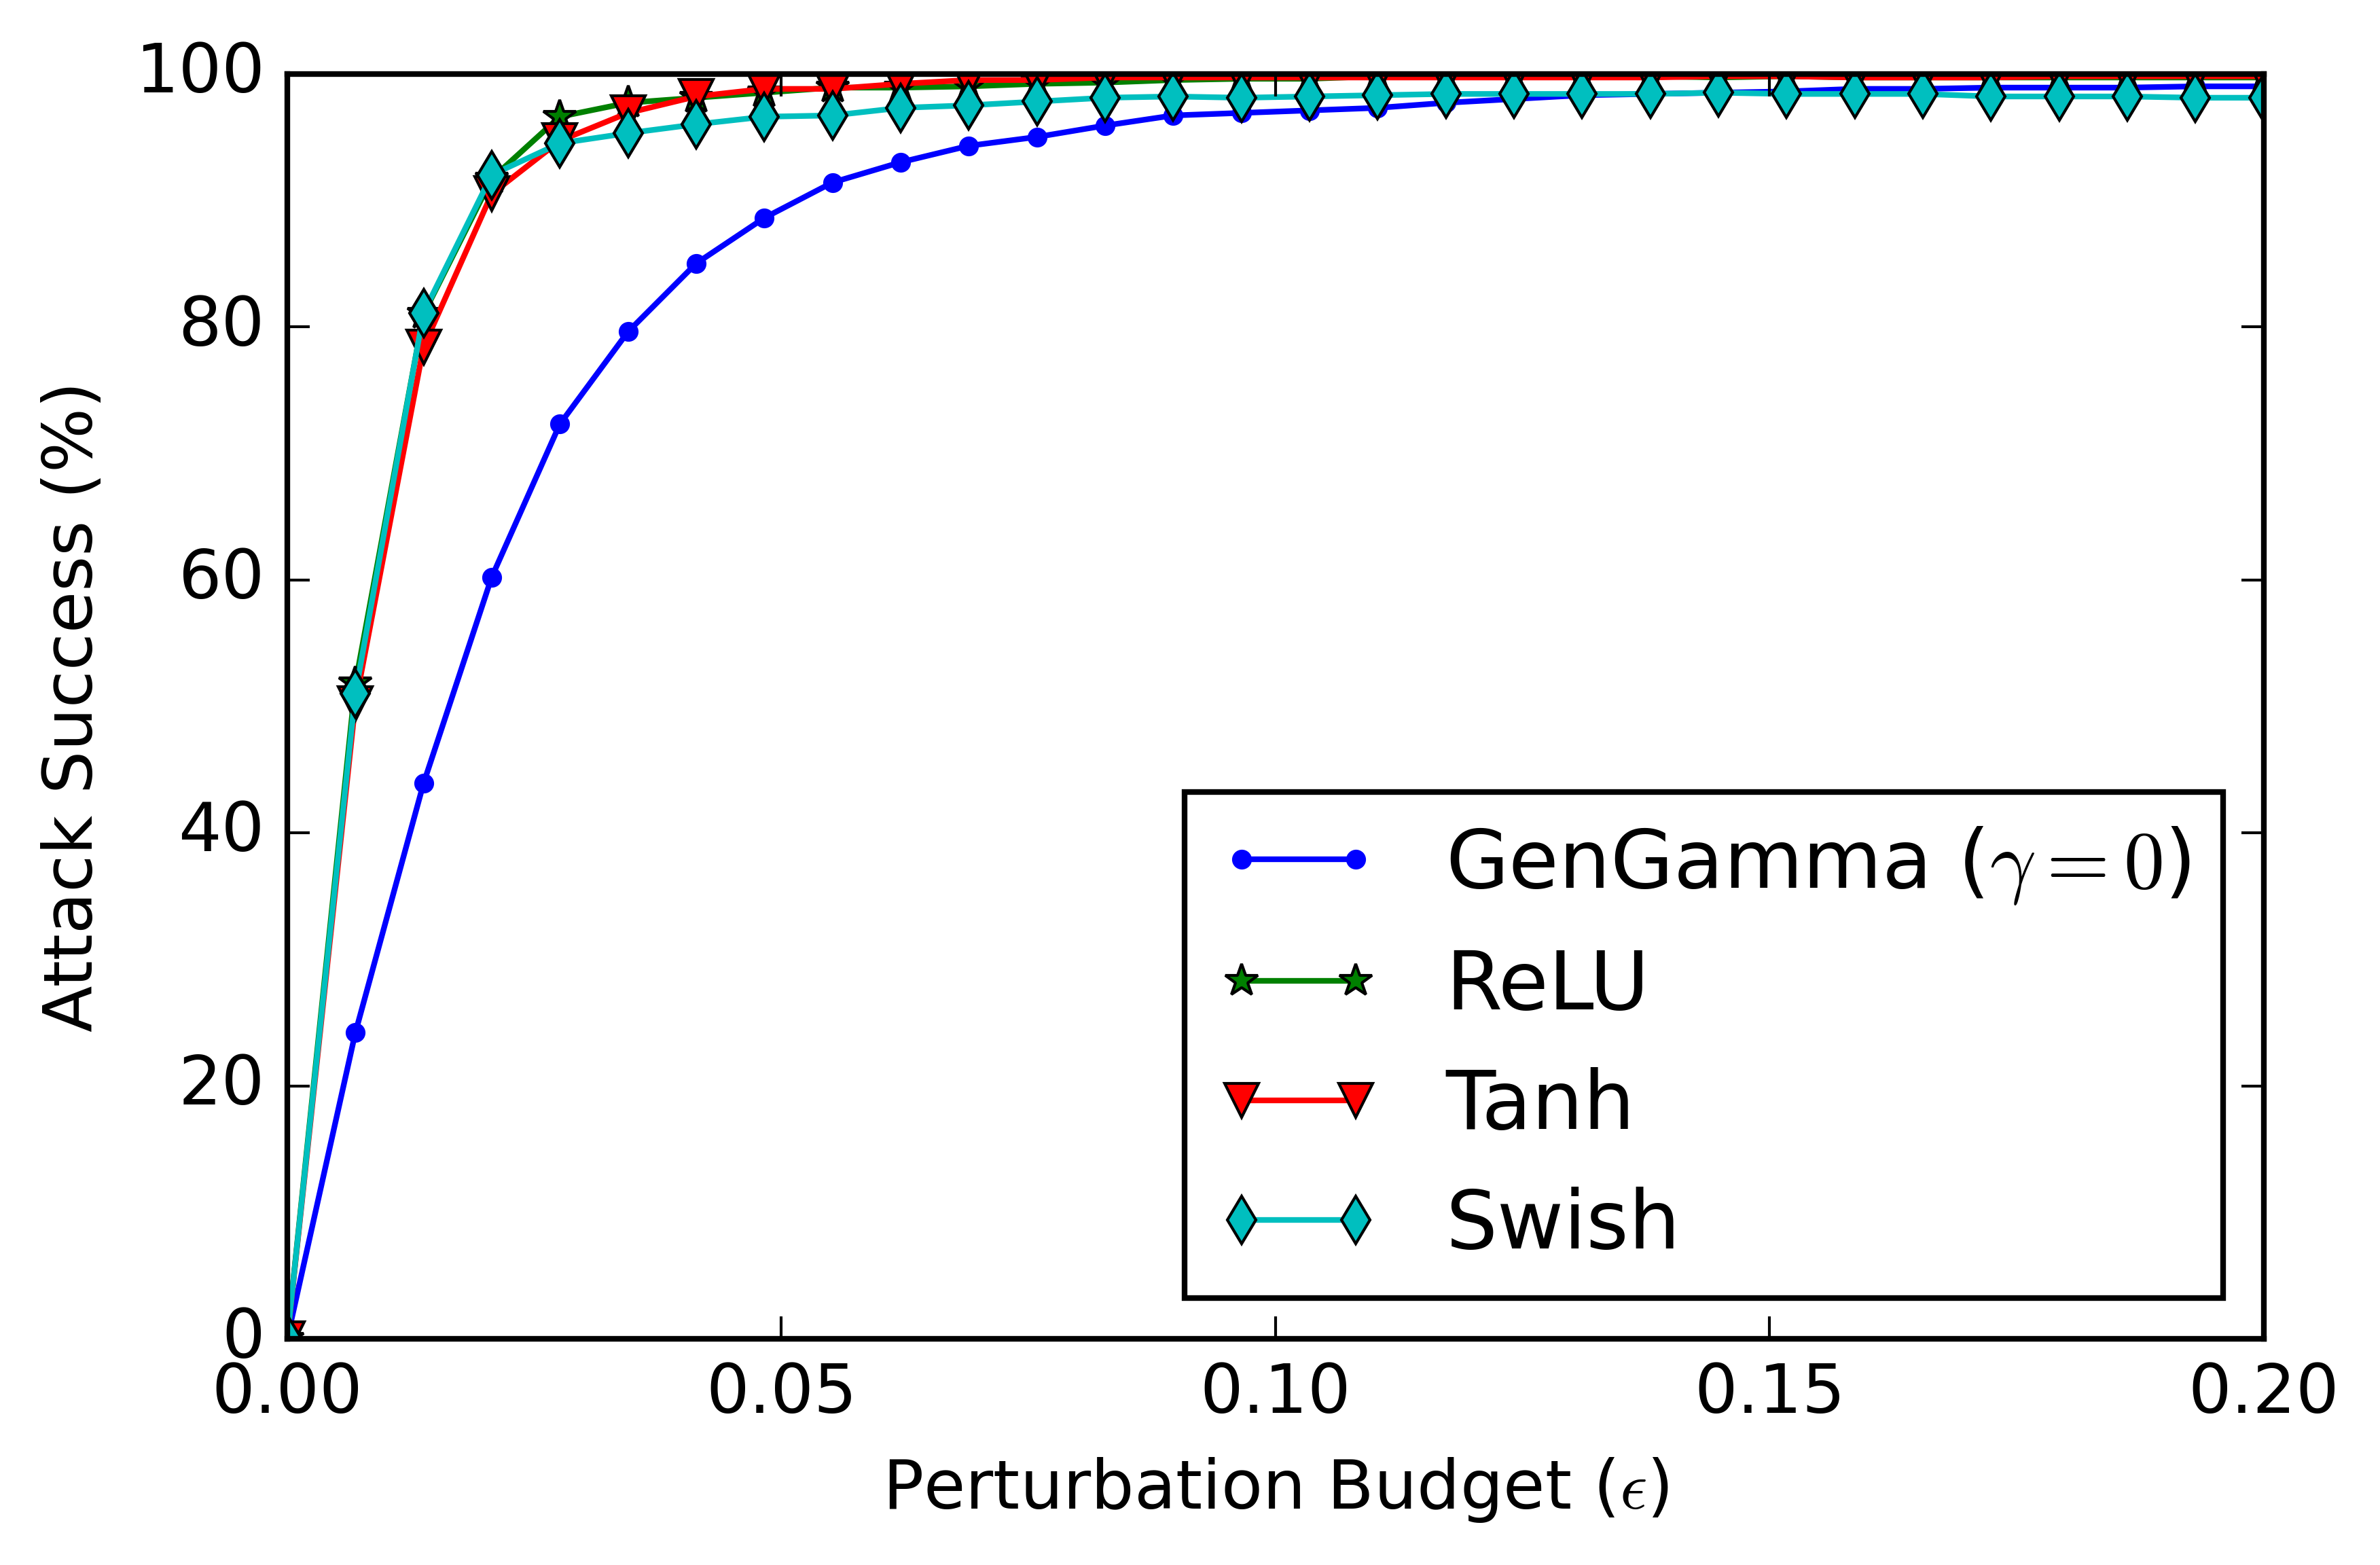

In [30]:
plt.figure(figsize=(5,4), dpi=600)
plt.plot(eps, attack_success(fgsm_results_gengamma), label='GenGamma', marker='.')
plt.plot(eps, attack_success(fgsm_results_relu), label='ReLU', marker='*')
plt.plot(eps, attack_success(fgsm_results_tanh), label='Tanh', marker='v')
plt.plot(eps, attack_success(fgsm_results_swish), label='Swish', marker='d')

plt.legend(loc='lower right')
axes = plt.gca()
axes.set_ylim([0, 100])
plt.xlabel('Perturbation Budget ($\epsilon$)')
plt.ylabel('Attack Success (%)')
plt.tight_layout()
plt.savefig('images/fgsm_results_lenet_cifar.png', dpi=600)
plt.show()

## PGD

In [36]:
pgd_results_gengamma = []
pgd_results_relu = []
pgd_results_tanh = []
pgd_results_swish = []

eps = np.linspace(0, 0.15, 15)
for epsilon in eps:
    pgd_results_gengamma += [pgd_attack(classifier, eval_x_test, eval_y_test, eps=epsilon)]
    pgd_results_relu += [pgd_attack(classifier_relu, eval_x_test_relu, eval_y_test_relu, eps=epsilon)]
    pgd_results_tanh += [pgd_attack(classifier_tanh, eval_x_test_tanh, eval_y_test_tanh, eps=epsilon)]
    pgd_results_swish += [pgd_attack(classifier_swish, eval_x_test_swish, eval_y_test_swish, eps=epsilon)]

    print("eps "+str(epsilon)+" done")

eps 0.0 done
eps 0.016666666666666666 done
eps 0.03333333333333333 done
eps 0.05 done
eps 0.06666666666666667 done
eps 0.08333333333333333 done
eps 0.1 done
eps 0.11666666666666667 done
eps 0.13333333333333333 done
eps 0.15 done


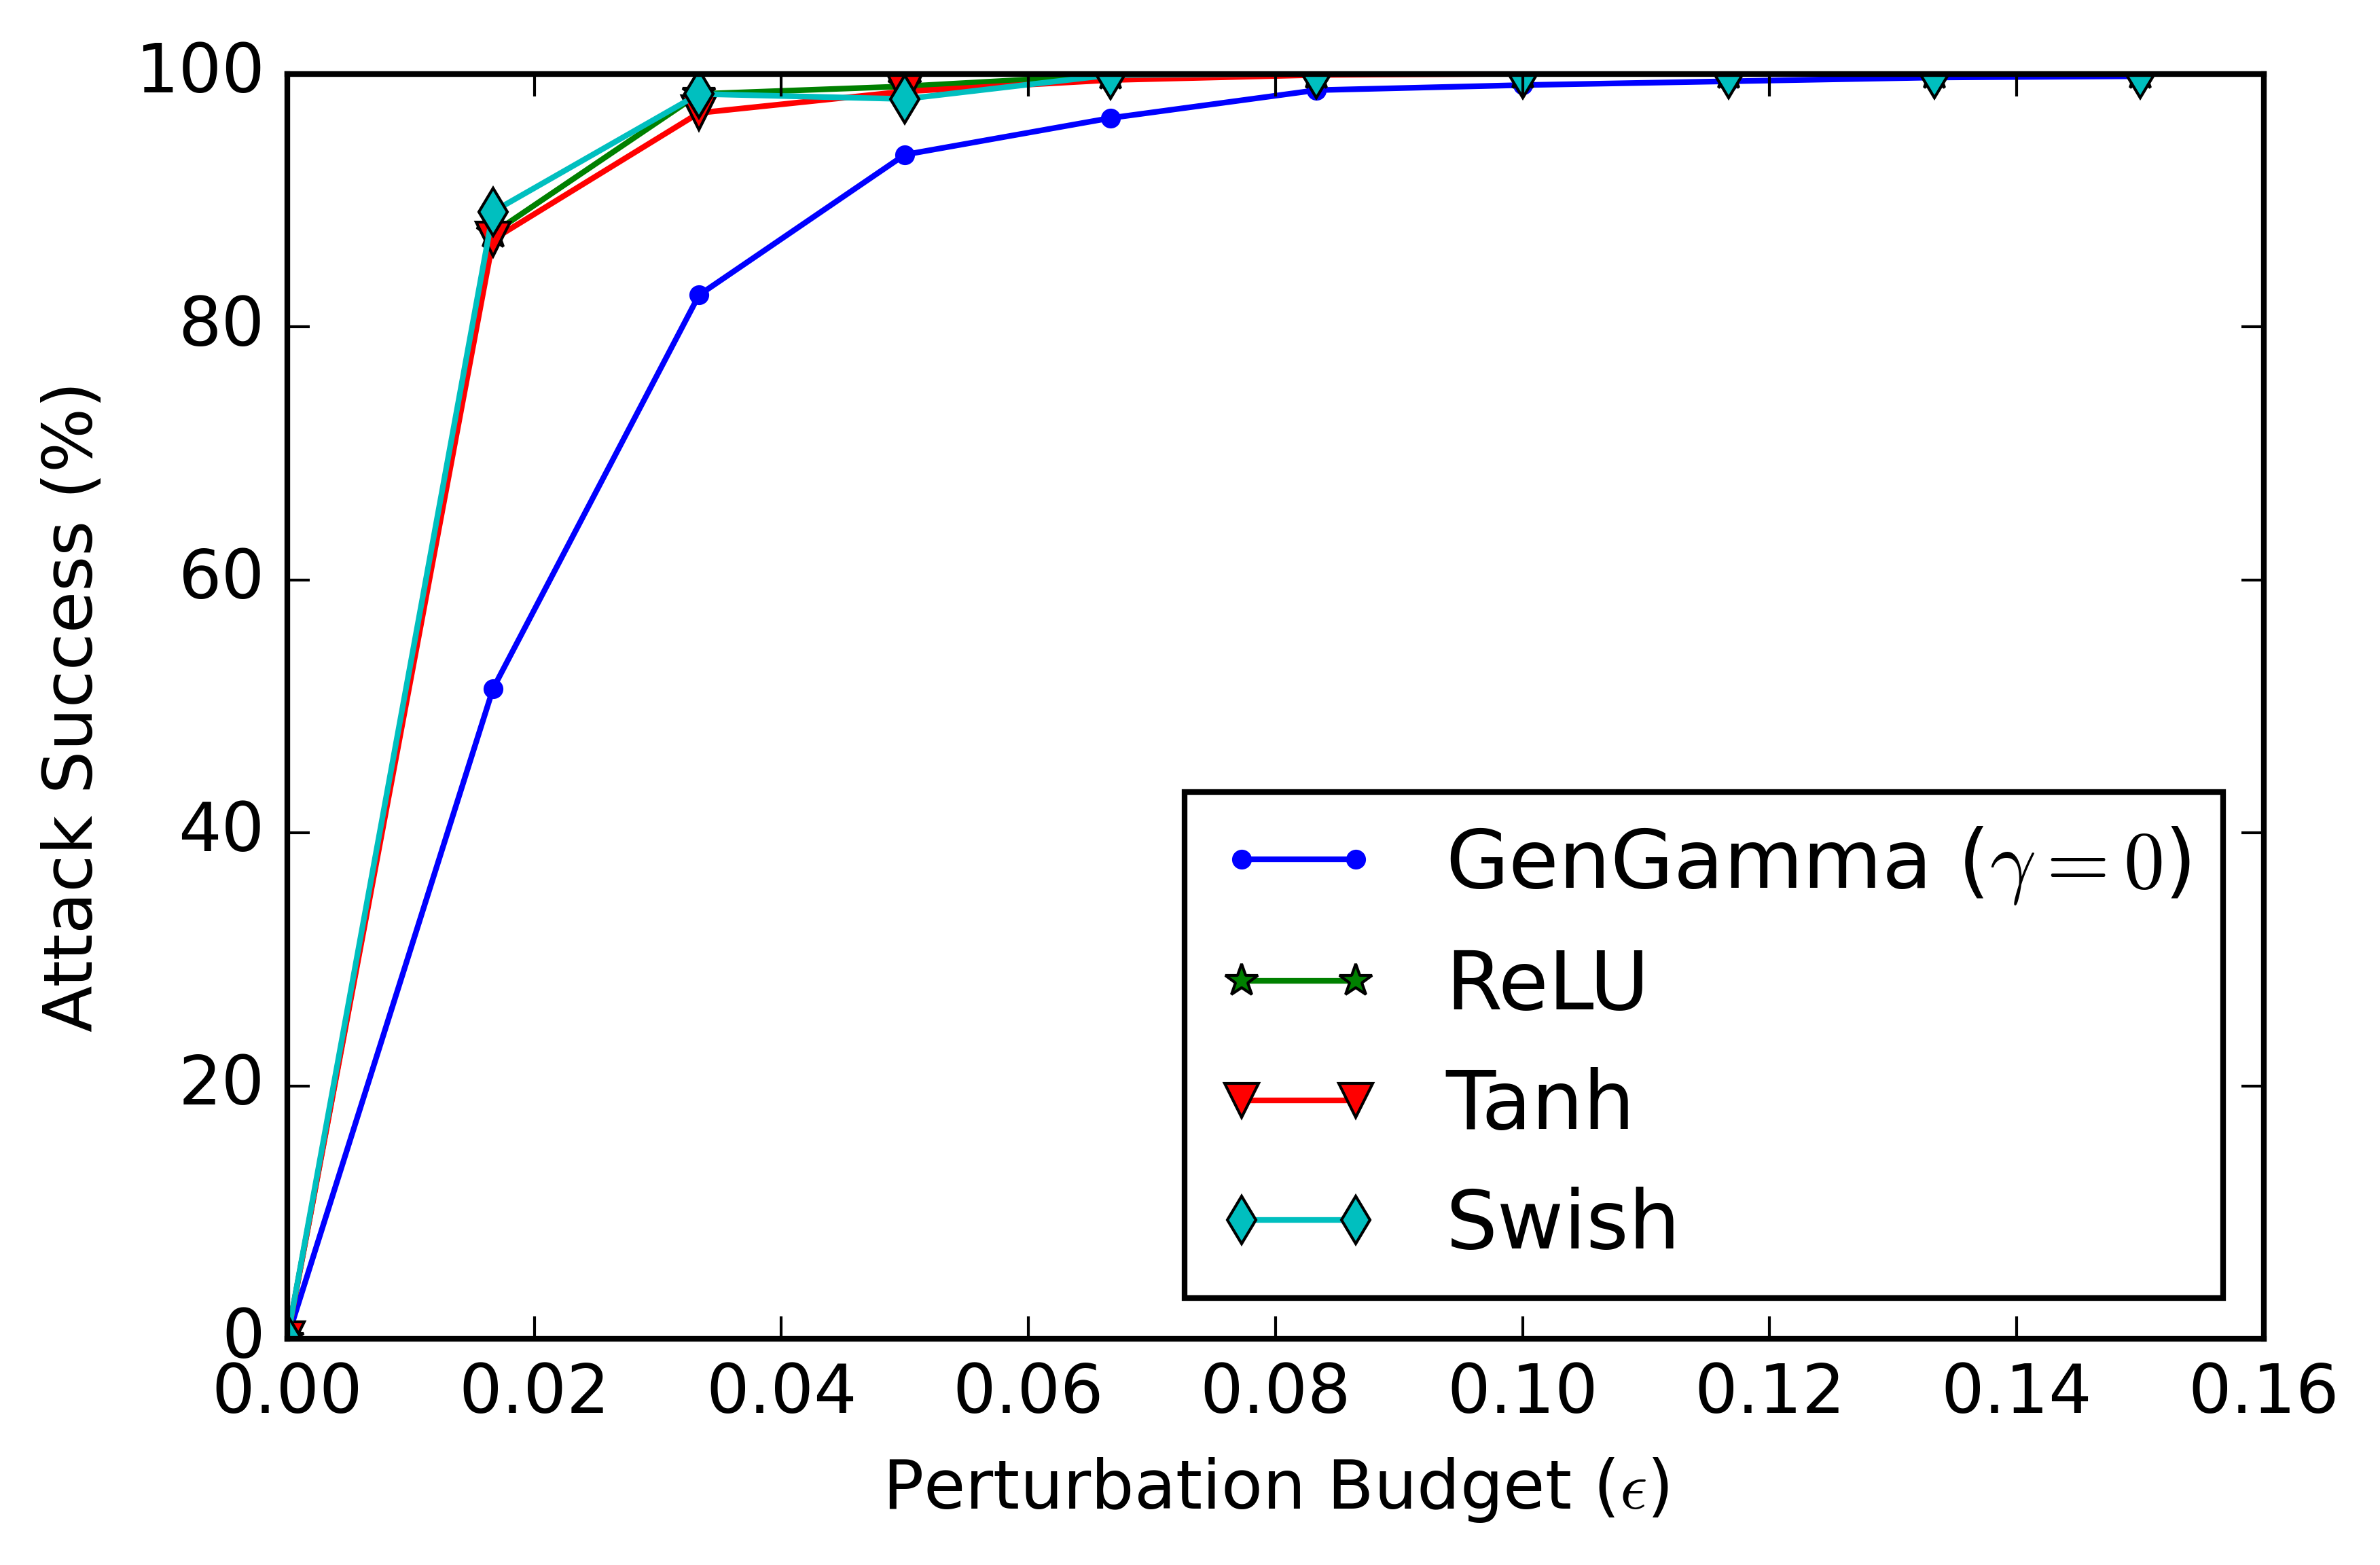

In [37]:
plt.figure(figsize=(5,4), dpi=600)

plt.plot(eps, attack_success(pgd_results_gengamma), label='GenGamma', marker='.')
plt.plot(eps, attack_success(pgd_results_relu), label='ReLU', marker='*')
plt.plot(eps, attack_success(pgd_results_tanh), label='Tanh', marker='v')
plt.plot(eps, attack_success(pgd_results_swish), label='Swish', marker='d')

plt.legend(loc='lower right')
axes = plt.gca()
axes.set_ylim([0, 100])
plt.xlabel('Perturbation Budget ($\epsilon$)')
plt.ylabel('Attack Success (%)')
plt.tight_layout()
plt.savefig('images/pgd_results_lenet_cifar.png', dpi=600)
plt.show()

## Carlini & Wagner L2/inf

In [38]:
## want a smaller eval size due to computational constraints
def get_successful_test(classifier, x_test, y_test):
    preds = np.argmax(classifier.predict(x_test), axis=1)
    acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
    print("Original test accuracy: %.2f%%" % (acc * 100))
    
    preds = np.argmax(classifier.predict(x_test), axis=1)
    correct = np.nonzero(preds == np.argmax(y_test, axis=1))

    eval_x_test = x_test[correct]
    eval_y_test = y_test[correct]

    eval_x_test_final = eval_x_test[:100]
    print(eval_x_test_final.shape)
    eval_y_test_final = eval_y_test[:100]
    print(eval_y_test_final.shape)
    
    preds = np.argmax(classifier.predict(eval_x_test_final), axis=1)
    acc = np.sum(preds == np.argmax(eval_y_test_final, axis=1)) / eval_y_test_final.shape[0]
    print("Test set of correctly predicted (benign): %.2f%%" % (acc * 100))
    
    return eval_x_test_final, eval_y_test_final

eval_x_test_gengamma, eval_y_test_gengamma = get_successful_test(classifier, x_test, y_test)
eval_x_test_relu, eval_y_test_relu = get_successful_test(classifier_relu, x_test, y_test)
eval_x_test_tanh, eval_y_test_tanh = get_successful_test(classifier_tanh, x_test, y_test)
eval_x_test_swish, eval_y_test_swish = get_successful_test(classifier_swish, x_test, y_test)

print(eval_x_test_gengamma.shape)

Original test accuracy: 47.63%
(100, 32, 32, 3)
(100, 10)
Test set of correctly predicted (benign): 100.00%
Original test accuracy: 58.26%
(100, 32, 32, 3)
(100, 10)
Test set of correctly predicted (benign): 100.00%
Original test accuracy: 61.07%
(100, 32, 32, 3)
(100, 10)
Test set of correctly predicted (benign): 100.00%
Original test accuracy: 56.14%
(100, 32, 32, 3)
(100, 10)
Test set of correctly predicted (benign): 100.00%
(100, 32, 32, 3)


In [39]:
cw_results_gengamma = []
cw_results_relu = []
cw_results_tanh = []
cw_results_swish = []

eps = np.linspace(0, 0.4, 4)
for epsilon in eps:
    cw_results_gengamma += [cwl2_attack(classifier, eval_x_test_gengamma, eval_y_test_gengamma, eps=epsilon)]
    cw_results_relu += [cwl2_attack(classifier_relu, eval_x_test_relu, eval_y_test_relu, eps=epsilon)]
    cw_results_tanh += [cwl2_attack(classifier_tanh, eval_x_test_tanh, eval_y_test_tanh, eps=epsilon)]
    cw_results_swish += [cwl2_attack(classifier_swish, eval_x_test_swish, eval_y_test_swish, eps=epsilon)]

    print("eps "+str(epsilon)+" done")

...creating adversarial examples


C&W L_2:   0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy on adversarial sample: 12.00%
[12.0]
[]
...creating adversarial examples


C&W L_2:   0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy on adversarial sample: 23.00%
[23.0]
...creating adversarial examples


C&W L_2:   0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy on adversarial sample: 3.00%
[3.0]
...creating adversarial examples


C&W L_2:   0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy on adversarial sample: 20.00%
[20.0]

eps 0.0 done

...creating adversarial examples


C&W L_2:   0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy on adversarial sample: 24.00%
[12.0, 24.0]
[]
...creating adversarial examples


C&W L_2:   0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy on adversarial sample: 23.00%
[23.0, 23.0]
...creating adversarial examples


C&W L_2:   0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy on adversarial sample: 0.00%
[3.0, 0.0]
...creating adversarial examples


C&W L_2:   0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy on adversarial sample: 20.00%
[20.0, 20.0]

eps 0.13333333333333333 done

...creating adversarial examples


C&W L_2:   0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy on adversarial sample: 36.00%
[12.0, 24.0, 36.0]
[]
...creating adversarial examples


C&W L_2:   0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy on adversarial sample: 23.00%
[23.0, 23.0, 23.0]
...creating adversarial examples


C&W L_2:   0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy on adversarial sample: 0.00%
[3.0, 0.0, 0.0]
...creating adversarial examples


C&W L_2:   0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy on adversarial sample: 20.00%
[20.0, 20.0, 20.0]

eps 0.26666666666666666 done

...creating adversarial examples


C&W L_2:   0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy on adversarial sample: 51.00%
[12.0, 24.0, 36.0, 51.0]
[]
...creating adversarial examples


C&W L_2:   0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy on adversarial sample: 23.00%
[23.0, 23.0, 23.0, 23.0]
...creating adversarial examples


C&W L_2:   0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy on adversarial sample: 0.00%
[3.0, 0.0, 0.0, 0.0]
...creating adversarial examples


C&W L_2:   0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy on adversarial sample: 20.00%
[20.0, 20.0, 20.0, 20.0]

eps 0.4 done



In [41]:
print(cw_results_gengamma)
print(cw_results_relu)
print(cw_results_tanh)
print(cw_results_swish)

[12.0, 24.0, 36.0, 51.0]
[23.0, 23.0, 23.0, 23.0]
[3.0, 0.0, 0.0, 0.0]
[20.0, 20.0, 20.0, 20.0]
